**Replication and Analysis of 'Volatility is rough' by Gatheral et al. - arxiv: 1410.3394** \
applied on S&P 500 \
computed by Alexander Zislin

import all relevant liabaries:

In [32]:
import pandas as pds
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kurtosis, skew
import scipy.stats as stats
import pylab

import oxford liabary:

In [33]:
data = pds.read_csv('oxfordmanrealizedvolatilityindices.csv')
spx = data[data["Symbol"] == ".SPX"]

extracting realized volatility:

In [34]:
rv = np.sqrt(spx["rsv"])
rv5 = np.sqrt(spx["rv5"])
rv10 = np.sqrt(spx["rv10"])

showing first linear correlation:

In [35]:
def plot_mq(rv):
    qs = np.array([0.25,0.5,1,1.5,2,3])
    deltas = np.arange(1,101)
    plt.figure(figsize=(5, 5))
    plt.xlabel('$\log(\Delta)$')
    plt.ylabel('$\log\  m(q.\Delta)$')
    for q in qs:
        mq = []
        for delta in deltas:
            mq.append(np.mean(abs(((np.log(rv)-np.log(rv).shift(delta)).dropna()))**q))
        x = np.linspace(1, 101, 100)
        y = np.polyfit(np.log(deltas),np.log(mq),deg=1)
        plt.plot(np.log(deltas),np.log(mq),'.',color='b')
        plt.plot(np.log(x),y[0]*np.log(x)+y[1],'-',color='r')
    return

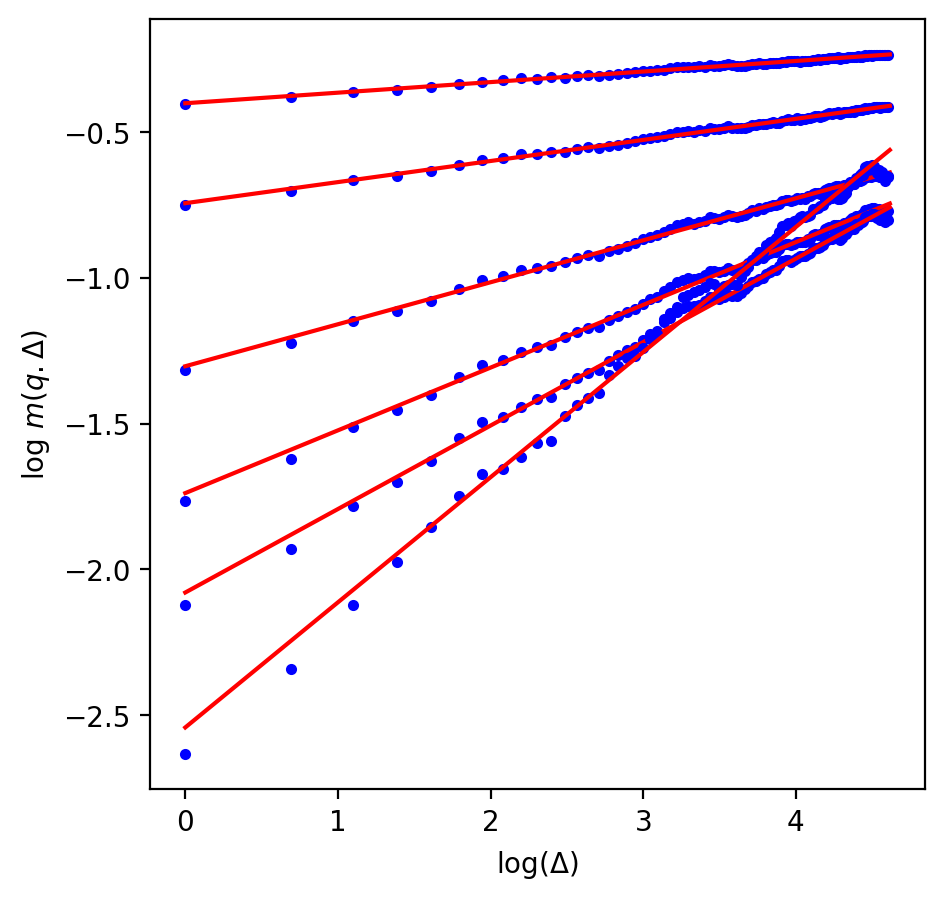

In [36]:
plot_mq(rv5)

function showing second linear correlation:

In [37]:
def plot_hq(rv):
    qs = np.array([0.25,0.5,1,1.5,2,3])
    deltas = np.arange(1,101)
    plt.figure(figsize=(5, 5))
    plt.xlabel('$q$')
    plt.ylabel('$s_q$')
    hq = []
    for q in qs:
        mq = []
        for delta in deltas:
            mq.append(np.mean(abs(((np.log(rv)-np.log(rv).shift(delta)).dropna()))**q))
        y = np.polyfit(np.log(deltas),np.log(mq),deg=1)
        hq.append(y[0])
    h = np.polyfit(qs,hq,deg=1)
    x = np.linspace(0, 3, 100)
    plt.plot(qs,hq,'.',color='b')
    plt.plot(x,h[0]*x+h[1],'-',color='r')
    return

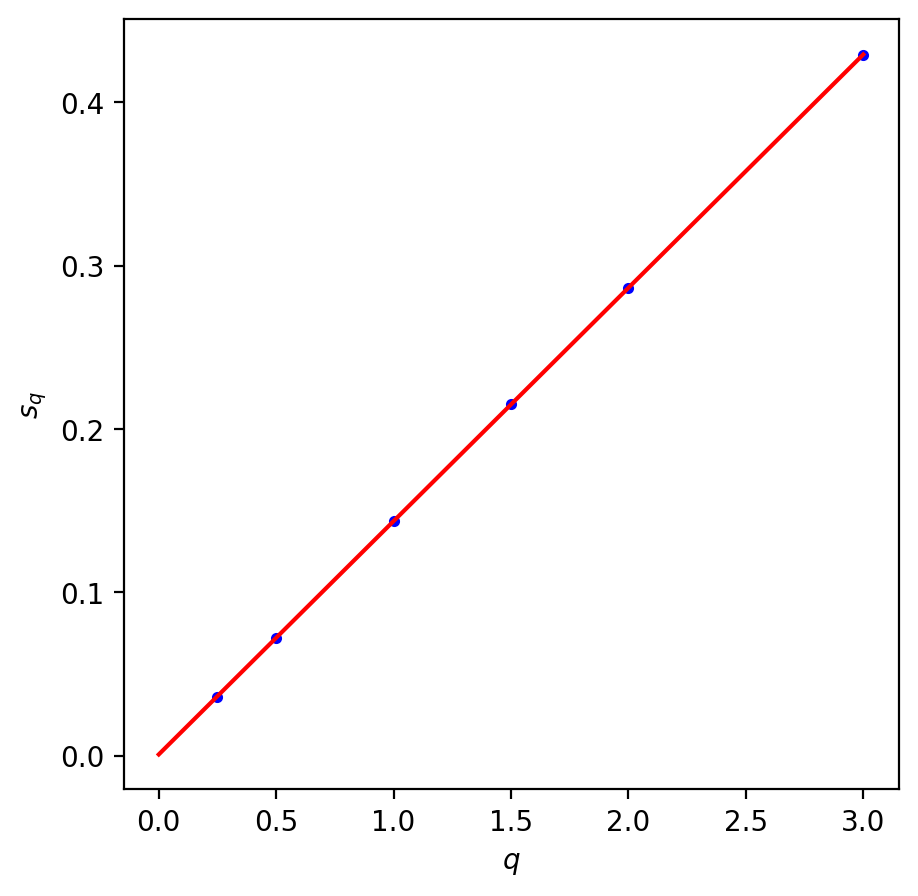

In [38]:
plot_hq(rv5)

function for estimating the hurst parameter (without plotting):

In [39]:
def hurst(rv):
    qs = np.array([0.25,0.5,1,1.5,2,3])
    deltas = np.arange(1,101)
    hq = []
    for q in qs:
        mq = []
        for delta in deltas:
            mq.append(np.mean(abs(((np.log(rv)-np.log(rv).shift(delta)).dropna()))**q))
        y = np.polyfit(np.log(deltas),np.log(mq),deg=1)
        hq.append(y[0])
    h = np.polyfit(qs,hq,deg=1)
    return h[0]

In [40]:
hurst(rv5)

0.14274070422823626

hurst parameter is biased. it differs from the realized volatility input you use, since the estimation of the realized variance process causes in smoothing the paths:

In [41]:
print('H for rv 1 min: '+str(hurst(rv)))
print('H for rv 5 min: '+str(hurst(rv5)))
print('H for rv 10 min: '+str(hurst(rv10)))

H for rv 1 min: 0.10327541538833518
H for rv 5 min: 0.14274070422823626
H for rv 10 min: 0.13175069413228635


also hurst parameter varies over time:

In [44]:
print('H for spx, first part: '+str(hurst(rv5[:round(len(rv5)/3)])))
print('H for spx, second part: '+str(hurst(rv5[round(len(rv5)/3):2*round(len(rv5)/3)])))
print('H for spx, third part: '+str(hurst(rv5[2*round(len(rv5)/3):])))

H for spx, first part: 0.09281140121114835
H for spx, second part: 0.12755124123388825
H for spx, third part: 0.1667216721458491


 function for estimating H and $\nu$ with linear regression using corollary 3.1 and special case q=2:

In [45]:
def parameter(rv):
    deltas = np.arange(1,101)
    m2deltas = []
    for delta in deltas:
        m2deltas.append(np.mean(((np.log(rv)-np.log(rv).shift(delta)).dropna())**2))
    y = np.polyfit(np.log(deltas),np.log(m2deltas),deg=1)
    h = y[0]/2
    nu = np.sqrt(np.exp(y[1]))
    return h, nu

as it is for the first method. parameters rely on the realized variance you use:

In [46]:
h_rv, nu_rv = parameter(rv)
print('H for rv 1 min: '+str(h_rv)+', nu for rv 1 min: '+str(nu_rv))
h_rv5, nu_rv5 = parameter(rv5)
print('H for rv 5 min: '+str(h_rv5)+', nu for rv 5 min: '+str(nu_rv5))
h_rv10, nu_rv10 = parameter(rv10)
print('H for rv 10 min: '+str(h_rv10)+', nu for rv 10 min: '+str(nu_rv10))

H for rv 1 min: 0.10377719970044934, nu for rv 1 min: 0.469425443262414
H for rv 5 min: 0.14312583202371473, nu for rv 5 min: 0.35364634465167544
H for rv 10 min: 0.13234626480679806, nu for rv 10 min: 0.3814022162503495


showing the scaling property for the increments:

In [47]:
def increments(rv,delta,hurst):
    # raw data
    raw_inc = (np.log(rv)-np.log(rv).shift(1)).dropna()
    mu_raw, std_raw = norm.fit(raw_inc)
    # delta data
    delta_inc = (np.log(rv)-np.log(rv).shift(delta)).dropna()
    mu_delta, std_delta = norm.fit(delta_inc)
    # plot
    plt.figure(figsize=(5, 5))
    plt.hist(delta_inc,bins=25,density=True)
    x = np.linspace(-2, 2, 100)
    pdf_delta = norm.pdf(x, mu_delta, std_delta)
    plt.plot(x, pdf_delta, '-', linewidth=2,color='b',label=r'$N(0,v^2_\Delta$)')
    if delta != 1:
        pdf_raw = norm.pdf(x, mu_raw, std_raw*delta**(hurst))
        plt.plot(x, pdf_raw, '--', linewidth=1,color='r',label=r'$N(0,v^2_1\Delta^{2H}$)')
    plt.grid(which='minor', color='white', lw = 0.5)
    plt.xlim(-2.5,2.5)
    plt.legend()
    plt.show()
    # properties
    kurtosis_delta = kurtosis(delta_inc)
    skew_delta = skew(delta_inc)
    return mu_delta, std_delta, kurtosis_delta, skew_delta

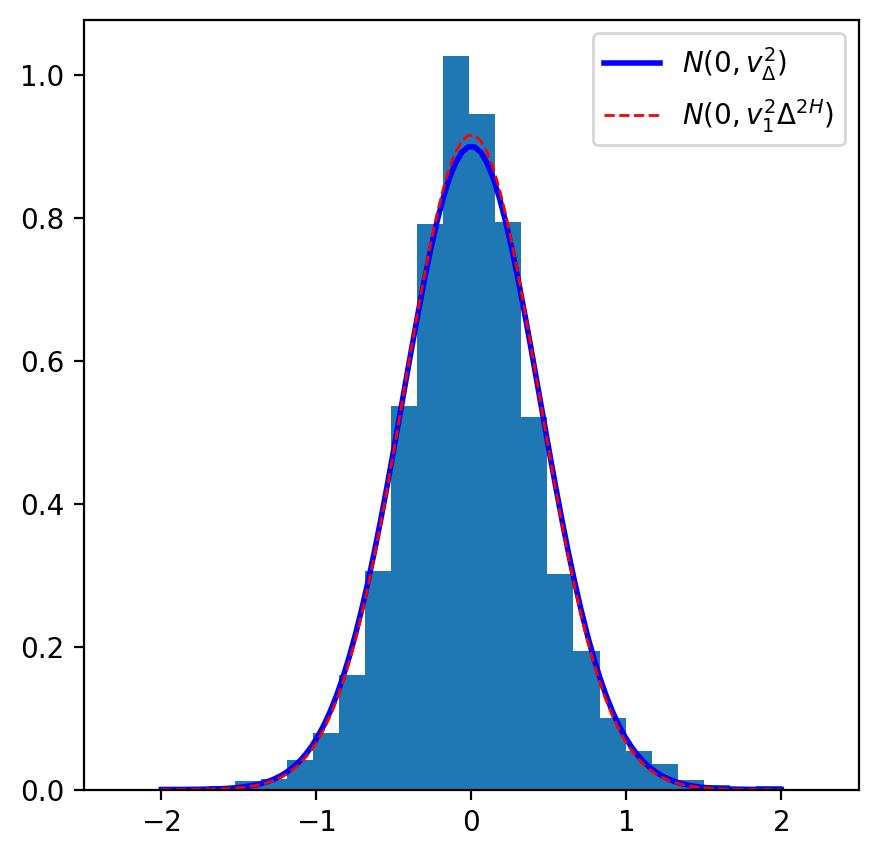

(6.241618300829989e-05,
 0.4433646158348582,
 1.0690516058503388,
 0.17097925325544006)

In [50]:
increments(rv5,5,h_rv5)